In [1]:
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykeen.triples import TriplesFactory

In [2]:
MODEL_ID = '38uz9fjs'

In [3]:
base_path = osp.join('..', 'models', MODEL_ID)

## Loading the data

The data loading section performs the following operations:

- Load the triples for training, validation and testing
- Load the list of diseases with attributes
- Count the number of times each entity appears in the training set

### Loading the triples

In [4]:
biokg_path = osp.join('..', 'data', 'biokgb')
graph_path = osp.join(biokg_path, 'graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'

train = TriplesFactory.from_path_binary(osp.join(base_path, 'training_triples'))
valid, test = [TriplesFactory.from_path(osp.join(graph_path, f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples)]

train_triples = pd.DataFrame(train.triples, columns=['head', 'relation', 'tail'])
test_triples = pd.DataFrame(test.triples, columns=['head', 'relation', 'tail'])

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


### Loading the list of diseases with attributes

We do this for the specific case of **diseases** because we want to compare the performance of the model on diseases vs non-diseases.

In [5]:
diseases_with_attributes = pd.read_csv(osp.join(biokg_path, 'properties', 'biokg_meshid_to_descr_name.tsv'),
                                       sep='\t', names=['id', 'description'])
diseases_with_attributes = set(diseases_with_attributes['id'].unique())

### Counting the number of times each entity appears in the training set

This is how we determine the degree of each entity.

In [6]:
# Count the number of times each entity appears in the training set
entity_counts = train_triples['head'].value_counts().add(train_triples['tail'].value_counts(), fill_value=0)

## Aggregating the results by degree

We want to compare the performance of the model on entities with different degrees. We do this by collecting the rank per triple, and then grouping by the degree of the entity.

In [7]:
def aggregate_results_by_degree(ranks_df):
    triples_and_ranks = test_triples.copy()
    mrr = 1.0 / ranks_df['mrr']

    # Here we assume that the ranks are comprised by two halves,
    # one for head prediction, and the other for tail prediction
    triples_and_ranks['head_mrr'] = mrr.iloc[:len(mrr) // 2].values
    triples_and_ranks['tail_mrr'] = mrr.iloc[len(mrr) // 2:].values

    # Add the number of times each entity appears in the training set (as head or tail)
    triples_and_ranks['head_degree'] = triples_and_ranks['head'].map(entity_counts).values.astype(int)
    triples_and_ranks['tail_degree'] = triples_and_ranks['tail'].map(entity_counts).values.astype(int)

    # Keep only the test triples that have a disease as head or (exclusive) tail
    head_disease_indicator = triples_and_ranks['head'].isin(diseases_with_attributes)
    tail_disease_indicator = triples_and_ranks['tail'].isin(diseases_with_attributes)
    triples_and_ranks = triples_and_ranks[head_disease_indicator ^ tail_disease_indicator]

    # Split into cases where disease is head and where disease is tail
    disease_at_head = triples_and_ranks[triples_and_ranks['head'].isin(diseases_with_attributes)]
    disease_at_tail = triples_and_ranks[triples_and_ranks['tail'].isin(diseases_with_attributes)]

    # We then get the two cases when the predicted entity is a disease or a non-disease
    disease_mrr = pd.concat([disease_at_head[['head_degree', 'head_mrr']].rename(columns={'head_degree': 'degree',
                                                                                             'head_mrr': 'mrr'}),
                             disease_at_tail[['tail_degree', 'tail_mrr']].rename(columns={'tail_degree': 'degree',
                                                                                             'tail_mrr': 'mrr'})],
                            axis=0, ignore_index=True)
    non_disease_mrr = pd.concat([disease_at_head[['tail_degree', 'tail_mrr']].rename(columns={'tail_degree': 'degree',
                                                                                             'tail_mrr': 'mrr'}),
                                 disease_at_tail[['head_degree', 'head_mrr']].rename(columns={'head_degree': 'degree',
                                                                                              'head_mrr': 'mrr'})],
                                axis=0, ignore_index=True)
    return disease_mrr, non_disease_mrr

The above separates the results into two:
- `disease_mrr`: the MRR of the model when the predicted entity is a disease
- `non_disease_mrr`: the MRR of the model when the predicted entity is a non-disease

We can now load this data for BioBLP and RotatE.

In [8]:
disease_mrr, non_disease_mrr = aggregate_results_by_degree(pd.read_csv(osp.join(base_path, 'ranks.csv'),
                                                                       sep='\t',
                                                                       header=None,
                                                                       names=['mrr']))

rotate_path = osp.join('..', 'models', '36viovqn')
rotate_disease_mrr, rotate_non_disease_mrr = aggregate_results_by_degree(pd.read_csv(osp.join(rotate_path, 'ranks.csv'),
                                                                                     sep='\t',
                                                                                     header=None,
                                                                                     names=['mrr']))

## Plotting the results

In [9]:
# Configure matplotlib fonts to use Helvetica Neue, with the default as fallback
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

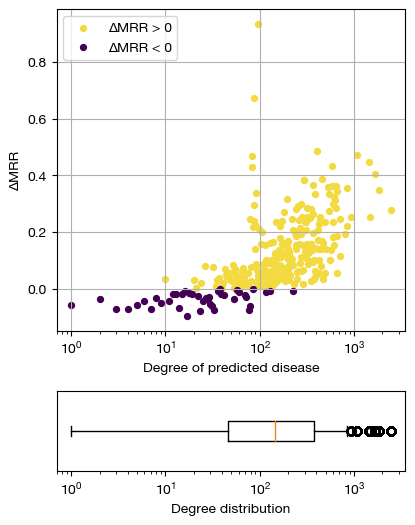

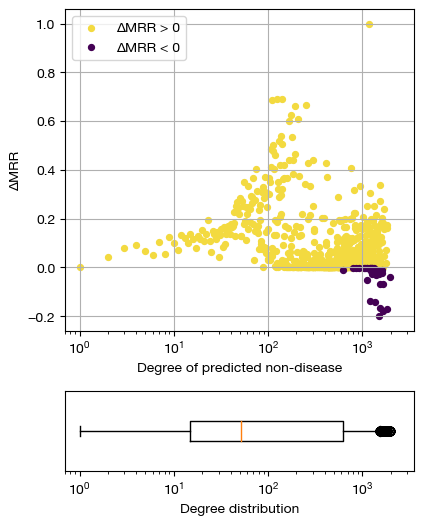

In [15]:
def plot_mrr_distribution(df, predicted_type):
    """Plots as a function of their degree"""
    mrr_by_degree = df.groupby('degree').mean()
    mrr_by_degree['count'] = df['degree'].value_counts()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), gridspec_kw={'height_ratios': [4, 1]})

    # First plot: scatter plot of MRR vs degree
    # Split the data into positive and negative values of MRR
    positive_mrr = mrr_by_degree[mrr_by_degree['mrr'] > 0]
    negative_mrr = mrr_by_degree[mrr_by_degree['mrr'] < 0]

    # We will color the points depending on whether the value is positive or negative
    # Use the viridis colormap
    ax1.scatter(positive_mrr.index, positive_mrr['mrr'], c='#f3da40ff', label='ΔMRR > 0', s=18)
    ax1.scatter(negative_mrr.index, negative_mrr['mrr'], c='#440154ff', label='ΔMRR < 0', s=18)

    # Add a legend for the colors
    ax1.set_xscale('log')
    ax1.set_xlabel(f'Degree of predicted {predicted_type}')
    ax1.set_ylabel('ΔMRR')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_xlim(0.7, 3.5e3)

    # Second plot: boxplot of degree distribution
    ax2.boxplot(df['degree'], vert=False)
    ax2.set_xscale('log')
    ax2.set_xlabel('Degree distribution')
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim(0.7, 1.3)
    ax2.set_xlim(0.7, 3.5e3)

    fig.subplots_adjust(hspace=0.3)

def get_mrr_difference(df1, df2):
    """Returns the difference in MRR between two dataframes"""
    mrr_diff = df1[['degree']]
    mrr_diff['mrr'] = df1['mrr'] - df2['mrr']
    return mrr_diff

plot_mrr_distribution(get_mrr_difference(rotate_disease_mrr, disease_mrr), predicted_type='disease')
plt.savefig('2023-06-05-degree-analysis-disease.pdf', bbox_inches='tight')
plot_mrr_distribution(get_mrr_difference(rotate_non_disease_mrr, non_disease_mrr), predicted_type='non-disease')
plt.savefig('2023-06-05-degree-analysis-nondisease.pdf', bbox_inches='tight')